# Imports

In [95]:
import gymnasium
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd

from collections import defaultdict
from environment import PowerGridEnv
from scenarios_utils import get_scenario

In [96]:
df_eco = pd.read_csv("eco2mix-national-tr.csv",delimiter=";")

In [97]:
scenario,cons_max,prod_max = get_scenario(df_eco)
battery_max = 25000

In [98]:
env = PowerGridEnv(scenario,battery_max=battery_max) 

In [99]:
def get_indice(observations):
    state_indices = [0,0,0,0]
    bins = [10,10,3,24]
    for i,o in enumerate(observations) :
        state_indices[i] = np.floor(o * (bins[i] - 1)).astype(int)
        state_indices[i] = np.clip(state_indices[i], 0, bins[i] - 1)
    return tuple(state_indices)

# Policy definition 

In [100]:
def epsilon_greedy(Q,s,epsilon):
    n_actions = 5 # Modifier si on change l'environnement et qu'on permet plus d'actions
    if np.random.random()<epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[s])


# Sarsa

In [101]:
def Sarsa(policy,alpha = 1,gamma=1, epsilon =0.3,n_episodes=100,Q = defaultdict(lambda: np.zeros(5))):
    gain_array = np.zeros(n_episodes)
    battery = []

    for i in range(n_episodes):
        epsilon = 1/(i+1)
        gain = 0
        count= 0
        done = False
        observations = env.reset()
        battery.append(observations[2])
        state=get_indice(observations)
        action = policy(Q,state,epsilon)
        while not done:
            count +=1
            next_observations,reward,done = env.step(action)
            next_state = get_indice(next_observations)
            next_action = policy(Q,next_state,epsilon)
            state=get_indice(observations)
            Q[state][action] =Q[state][action] +alpha*(reward+gamma*Q[next_state][next_action]-Q[state][action])
            observations = next_observations
            battery.append(observations[2])
            action = next_action
            gain +=reward
        gain_array[i] = gain/count
    return Q,gain_array,battery


    

In [102]:
Q_500,gain_array_sarsa,battery_sarsa = Sarsa(epsilon_greedy,n_episodes=250)

Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Puissance exigée non disponible
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur 

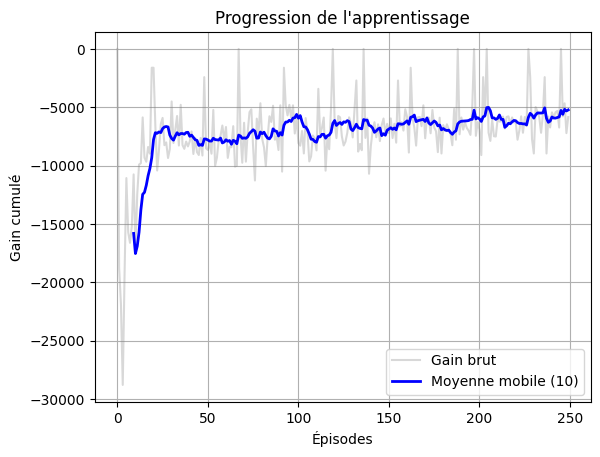

In [103]:
window_size =10  # Tu peux augmenter ce chiffre pour lisser encore plus
rolling_mean_sarsa = pd.Series(gain_array_sarsa).rolling(window=window_size).mean()

# On trace les deux pour comparer
plt.plot(gain_array_sarsa, alpha=0.3, label='Gain brut', color='gray') # Le brut en fond transparent
plt.plot(rolling_mean_sarsa, label=f'Moyenne mobile ({window_size})', color='blue', linewidth=2)

plt.title('Progression de l\'apprentissage')
plt.xlabel('Épisodes')
plt.ylabel('Gain cumulé')
plt.legend()
plt.grid(True)
plt.show()

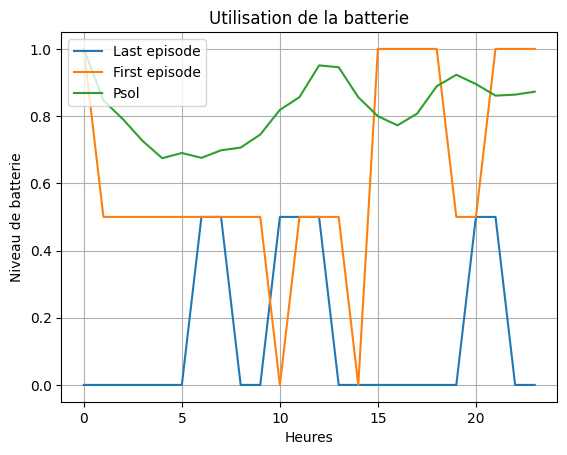

In [104]:
psol_array = scenario[:,1]
plt.plot(battery_sarsa[-24:])
plt.plot(battery_sarsa[:24])
plt.plot(psol_array/psol_array.max())
plt.title('Utilisation de la batterie')
plt.xlabel('Heures')
plt.ylabel('Niveau de batterie')
plt.legend(["Last episode","First episode","Psol"])
plt.grid(True)
plt.show()

# Q-Learning

In [105]:
def Qlearning(policy,alpha = 1,gamma=1, epsilon =0.3,n_episodes=100,Q = defaultdict(lambda: np.zeros(5))):
    gain_array = np.zeros(n_episodes)
    battery = []

    for i in range(n_episodes):
        epsilon = 1/(i+1)
        gain = 0
        count= 0
        done = False
        observations = env.reset()
        battery.append(observations[2])
        state=get_indice(observations)
        while not done:
            action = policy(Q,state,epsilon)
            count +=1
            next_observations,reward,done = env.step(action)
            next_state = get_indice(next_observations)
            state=get_indice(observations)
            Q[state][action] =Q[state][action] +alpha*(reward+gamma*np.max(Q[next_state])-Q[state][action])
            observations = next_observations
            state=get_indice(observations)
            battery.append(observations[2])
            gain +=reward
        gain_array[i] = gain/count
    return Q,gain_array,battery


    

In [106]:
Ql,gain_Ql,battery_Ql = Qlearning(epsilon_greedy,n_episodes=250)

Battery supérieur au max
Puissance exigée non disponible
Puissance exigée non disponible
Puissance exigée non disponible
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Puissance exigée non disponible
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Battery supérieur au max
Puissance exigée non disponible
Battery supérie

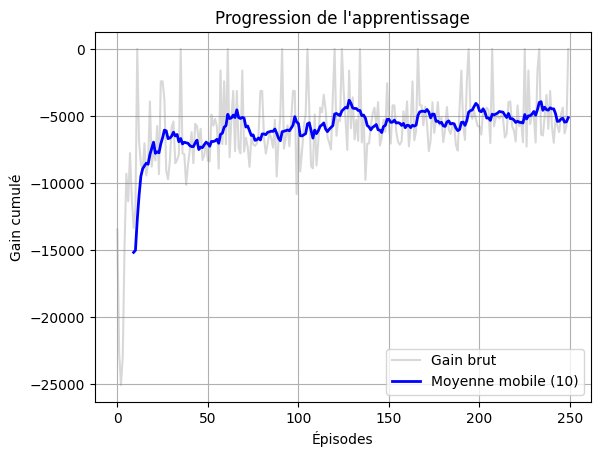

In [107]:
window_size =10  # Tu peux augmenter ce chiffre pour lisser encore plus
rolling_mean_Ql = pd.Series(gain_Ql).rolling(window=window_size).mean()

# On trace les deux pour comparer
plt.plot(gain_Ql, alpha=0.3, label='Gain brut', color='gray') # Le brut en fond transparent
plt.plot(rolling_mean_Ql, label=f'Moyenne mobile ({window_size})', color='blue', linewidth=2)

plt.title('Progression de l\'apprentissage')
plt.xlabel('Épisodes')
plt.ylabel('Gain cumulé')
plt.legend()
plt.grid(True)
plt.show()

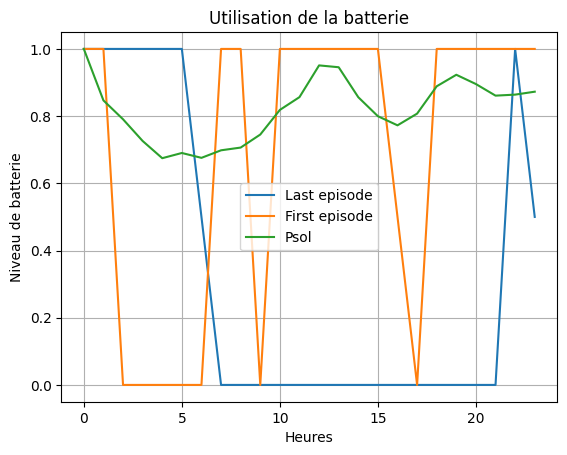

In [108]:
psol_array = scenario[:,1]
plt.plot(battery_Ql[-24:])
plt.plot(battery_Ql[:24])
plt.plot(psol_array/psol_array.max())
plt.title('Utilisation de la batterie')
plt.xlabel('Heures')
plt.ylabel('Niveau de batterie')
plt.legend(["Last episode","First episode","Psol"])
plt.grid(True)
plt.show()

# Comparaison Sarsa Vs Qlearning

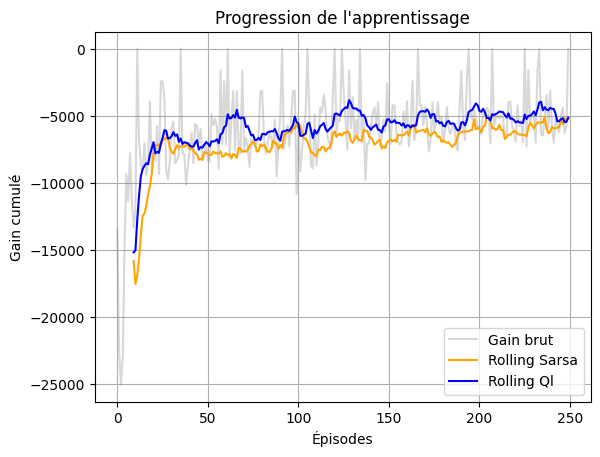

In [ ]:
# On trace les deux pour comparer
plt.plot(gain_Ql, alpha=0.3, label='Gain brut (du Qlearning)', color='gray') # Le brut en fond transparent
plt.plot(rolling_mean_sarsa,  label='Rolling Sarsa', color='orange') # Le brut en fond transparent
plt.plot(rolling_mean_Ql, label=f'Rolling Ql', color='blue',)

plt.title('Progression de l\'apprentissage')
plt.xlabel('Épisodes')
plt.ylabel('Gain cumulé')
plt.legend()
plt.grid(True)
plt.show()